In [36]:
import pandas as pd

df = pd.read_csv("C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Annotation/Annotation_For3Class.csv")
print(df.head())
print(df.isnull().sum())


          ImagePath    X0    X1   Y0   Y1               Class
0  000015335564.jpg    80   116  477  514  ADVISORY SPEED MPH
1  000015340509.jpg  1720  1760  485  526  ADVISORY SPEED MPH
2  000016400582.jpg    50    76  468  490  ADVISORY SPEED MPH
3  000016450565.jpg  1765  1840  517  590  ADVISORY SPEED MPH
4  000024250089.jpg   354   428  430  504  ADVISORY SPEED MPH
ImagePath    0
X0           0
X1           0
Y0           0
Y1           0
Class        0
dtype: int64


In [13]:
import os
import pandas as pd
from PIL import Image

# Load the CSV file
df = pd.read_csv("C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Annotation/Annotation_For3Class.csv")

# Rename columns
df.rename(columns={
    'ImagePath': 'filename',
    'X0': 'xmin',
    'X1': 'xmax',
    'Y0': 'ymin',
    'Y1': 'ymax',
    'Class': 'class'
}, inplace=True)

# Correct class list — only names, not paths
classes = ['DIRECTIONAL ARROW AUXILIARY', 'DO NOT ENTER', 'ADVISORY SPEED MPH']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

def convert_to_yolo(df, img_folder, yolo_label_dir):
    os.makedirs(yolo_label_dir, exist_ok=True)
    for index, row in df.iterrows():
        img_name = row['filename']
        class_name = row['class']
        try:
            cls_id = class_to_idx[class_name]
        except KeyError:
            print(f"Unknown class name: {class_name}")
            continue

        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        img_path = os.path.join(img_folder, class_name, img_name)  # Change if not in subfolders

        try:
            img = Image.open(img_path)
            w, h = img.size

            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            bbox_width = (xmax - xmin) / w
            bbox_height = (ymax - ymin) / h

            label_path = os.path.join(yolo_label_dir, os.path.splitext(img_name)[0] + ".txt")
            with open(label_path, 'a') as f:
                f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

# Example usage
convert_to_yolo(df, "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Dataset", "./labels")


In [15]:
import os
import shutil
import random
import pandas as pd

# Paths
base_img_dir = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Dataset"
label_dir = "./labels"
output_base = "./dataset"

# Create YOLO folders
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_base, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(output_base, 'labels', split), exist_ok=True)

# Load the CSV again
df = pd.read_csv("C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Annotation/Annotation_For3Class.csv")
df.rename(columns={
    'ImagePath': 'filename',
    'Class': 'class'
}, inplace=True)

# Get unique images
all_images = df['filename'].unique().tolist()
random.shuffle(all_images)

# 80-20 train/val split
split_idx = int(0.8 * len(all_images))
train_images = set(all_images[:split_idx])
val_images = set(all_images[split_idx:])

# Copy files
for index, row in df.iterrows():
    img_name = row['filename']
    class_name = row['class']
    src_img_path = os.path.join(base_img_dir, class_name, img_name)
    src_label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")

    if img_name in train_images:
        split = 'train'
    elif img_name in val_images:
        split = 'val'
    else:
        continue

    dst_img_path = os.path.join(output_base, 'images', split, img_name)
    dst_label_path = os.path.join(output_base, 'labels', split, os.path.splitext(img_name)[0] + ".txt")

    try:
        shutil.copy(src_img_path, dst_img_path)
        shutil.copy(src_label_path, dst_label_path)
    except Exception as e:
        print(f"Error copying {img_name}: {e}")


In [17]:
import yaml

# Configuration
dataset_yaml = {
    'train': 'C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Dataset/images/train',
    'val': 'C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Dataset/images/val',
    'nc': 3,
    'names': ['DIRECTIONAL ARROW AUXILIARY', 'DO NOT ENTER', 'ADVISORY SPEED MPH']
}

# Write to dataset.yaml
with open('dataset.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False)

print("✅ dataset.yaml created successfully.")


✅ dataset.yaml created successfully.


In [ ]:
from ultralytics import YOLO

# Load base YOLOv8 model
model = YOLO("yolov8n.pt")  # or try yolov8s.pt for better accuracy (if resources allow)

# Train on custom dataset
model.train(
    data="dataset.yaml",     # Uses your correctly formatted YAML
    epochs=50,               # You can increase later if needed
    imgsz=416,               # You can experiment with 640 as well
    batch=4,                 # Tune based on available memory
    workers=2,
    seed=42
)


New https://pypi.org/project/ultralytics/8.3.105 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.101  Python-3.12.4 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i9-12900K)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=50, time=None, patience=100, batch=4, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Dataset\labels\train.cache... 4488 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4488/4488 [00:00<?, ?it/s]
val: Scanning C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Dataset\labels\val.cache... 1122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1122/1122 [00:00<?, ?it/s]


Plotting labels to runs\detect\train9\labels.jpg... 


In [ ]:
from ultralytics import YOLO

# Load base YOLOv8 model
model = YOLO("yolov8n.pt")  

# Train on custom dataset
model.train(
    data="dataset.yaml",     
    epochs=50,              
    imgsz=416,              
    batch=4,                
    workers=2,
    seed=42
)


In [ ]:
import os

label_dir = r"C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Dataset\labels"

for split in ["train", "val"]:
    split_dir = os.path.join(label_dir, split)
    for file in os.listdir(split_dir):
        path = os.path.join(split_dir, file)
        with open(path, 'r') as f:
            lines = f.readlines()
        unique_lines = list(set(lines))
        with open(path, 'w') as f:
            f.writelines(unique_lines)


In [13]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/runs/detect/train11/weights/best.pt")

# Predict on a test image
results = model("C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Object_Tracking/Images/20211130.135952_000006701368.jpg", save=True)

# Optional: Show the image
results[0].show()



image 1/1 C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Images\20211130.135952_000006701368.jpg: 256x416 (no detections), 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 416)
Results saved to runs\detect\predict6


In [22]:
from ultralytics import YOLO
import os
from glob import glob
import cv2
from pathlib import Path
# Load trained model
model = YOLO("C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/runs/detect/train11/weights/best.pt")

# Path to test images
test_img_dir = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Object_Tracking/Images/"
output_csv = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/runs/predict/predictions.csv"

# Run inference on all images in the folder
results = model.predict(
    source=test_img_dir,
    save=True,           # Save images with predicted boxes
    conf=0.25,           # Confidence threshold
    imgsz=416
)

# Prepare to write predictions to CSV
csv_rows = [("Image", "Class", "Confidence", "X1", "Y1", "X2", "Y2")]
names = model.names  # class names

print("\n🔍 Predictions:")
for r in results:
    img_name = Path(r.path).name
    boxes = r.boxes

    print(f"\n📌 Image: {img_name}")
    if boxes:
        for box in boxes:
            cls_id = int(box.cls.item())
            conf = float(box.conf.item())
            x1, y1, x2, y2 = map(float, box.xyxy[0])  # Bounding box
            class_name = names[cls_id]
            print(f" - Class: {class_name:30} | Confidence: {conf:.2f}")

            # Add to CSV rows
            csv_rows.append((img_name, class_name, f"{conf:.4f}", f"{x1:.1f}", f"{y1:.1f}", f"{x2:.1f}", f"{y2:.1f}"))
    else:
        print(" - No objects detected.")
        csv_rows.append((img_name, "No detection", "", "", "", "", ""))

# Save all predictions to a CSV file
with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(csv_rows)

print(f"\n✅ All predictions written to: {output_csv}")


image 1/232 C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Images\20211124.094905_000002948348.jpg: 256x416 (no detections), 51.1ms
image 2/232 C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Images\20211124.102244_000000431452.jpg: 256x416 (no detections), 45.1ms
image 3/232 C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Images\20211124.102244_000000437901.jpg: 256x416 (no detections), 44.7ms
image 4/232 C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Images\20211124.102244_000000444392.jpg: 256x416 (no detections), 46.0ms
image 5/232 C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Images\20211124.102806_000000412087.jpg: 256x416 (no detections), 42.5ms
image 6/232 C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Images\20211124.102806_000000418555.jpg: 256x416 (no detections)

NameError: name 'csv' is not defined

In [27]:
from ultralytics import YOLO
import cv2
import csv
from pathlib import Path

# Load the trained model
model = YOLO("C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/runs/detect/train11/weights/best.pt")

# Path to input video
video_path = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Object_Tracking/Video/UnSeen_Dataset.mp4"

# Output CSV file to store predictions
output_csv = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/runs/predict/video_predictions.csv"

# Run inference on the video
results = model.predict(
    source=video_path,
    conf=0.25,
    imgsz=416,
    save=True,           # Saves output video in same folder as weights
    save_txt=False,      # Set to True if you want YOLO format txt output per frame
    stream=False         # Set to True for real-time processing
)

# Prepare to write predictions to CSV
csv_rows = [("Frame", "Class", "Confidence", "X1", "Y1", "X2", "Y2")]
names = model.names  # class names

print("\n🔍 Predictions on Video:")
for r in results:
    frame_id = Path(r.path).stem
    boxes = r.boxes

    if boxes:
        for box in boxes:
            cls_id = int(box.cls.item())
            conf = float(box.conf.item())
            x1, y1, x2, y2 = map(float, box.xyxy[0])
            class_name = names[cls_id]

            print(f"🎯 Frame: {frame_id} | Class: {class_name:30} | Confidence: {conf:.2f}")
            csv_rows.append((frame_id, class_name, f"{conf:.4f}", f"{x1:.1f}", f"{y1:.1f}", f"{x2:.1f}", f"{y2:.1f}"))
    else:
        print(f"🕳️ Frame: {frame_id} | No objects detected.")
        csv_rows.append((frame_id, "No detection", "", "", "", "", ""))

# Write predictions to CSV
with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(csv_rows)

print(f"\n✅ All video predictions written to: {output_csv}")




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/232) C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Video\UnSeen_Dataset.mp4: 256x416 (no detections), 370.9ms
video 1/1 (frame 2/232) C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Video\UnSeen_Dataset.mp4: 256x416 (no detections), 263.5ms
video 1/1 (frame 3/232) C:\Users\user\Downloads\Assignment-20250409T022654Z-001\Assignment\Object_Tracking\Video\UnSeen_Datase

In [73]:
import cv2
import pandas as pd
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import os

# Load YOLOv8 model (Update path accordingly)
model_path = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/runs/detect/train11/weights/best.pt"
model = YOLO(model_path)

# Input video path
video_path = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Object_Tracking/Video/UnSeen_Dataset.mp4"
cap = cv2.VideoCapture(video_path)

# Output video path
out_path = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/tracked/tracked_output.avi"
width, height = int(cap.get(3)), int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)

# To store results
output_data = []
frame_num = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1

    # Convert to RGB for YOLO
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Run YOLOv8 detection
    results = model.predict(source=rgb_frame, conf=0.2, iou=0.5, classes=None, verbose=False)

    # Prepare detections for DeepSORT
    detections = []
    boxes = results[0].boxes

    if boxes is not None and len(boxes) > 0:
        for box in boxes:
            x1, y1, x2, y2 = map(float, box.xyxy[0])
            conf = float(box.conf.item())
            cls_id = int(box.cls.item())
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, cls_id))

    # Update tracker
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)

        class_name = model.names[track.det_class] if hasattr(track, "det_class") else "unknown"

        # Draw tracking box and label
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{class_name} ID:{track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Store data
        output_data.append({
            "Frame": frame_num,
            "Track_ID": track_id,
            "Class": class_name,
            "X1": x1,
            "Y1": y1,
            "X2": x2,
            "Y2": y2
        })

    # Write frame to output video
    out.write(frame)

    # Optional debug message
    print(f"[Frame {frame_num}] Tracks: {len(tracks)}")

# Release everything
cap.release()
out.release()

# Save output as CSV
df = pd.DataFrame(output_data)
csv_path = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/tracked/tracked_results.csv"
df.to_csv(csv_path, index=False)

print("✅ Tracking complete.")
print(f"📁 Results saved to: {csv_path}")
print(f"🎞️ Tracked video saved to: {out_path}")


[Frame 1] Tracks: 0
[Frame 2] Tracks: 0
[Frame 3] Tracks: 0
[Frame 4] Tracks: 1
[Frame 5] Tracks: 0
[Frame 6] Tracks: 1
[Frame 7] Tracks: 1
[Frame 8] Tracks: 0
[Frame 9] Tracks: 0
[Frame 10] Tracks: 0
[Frame 11] Tracks: 0
[Frame 12] Tracks: 0
[Frame 13] Tracks: 0
[Frame 14] Tracks: 1
[Frame 15] Tracks: 0
[Frame 16] Tracks: 0
[Frame 17] Tracks: 0
[Frame 18] Tracks: 0
[Frame 19] Tracks: 0
[Frame 20] Tracks: 0
[Frame 21] Tracks: 0
[Frame 22] Tracks: 1
[Frame 23] Tracks: 0
[Frame 24] Tracks: 0
[Frame 25] Tracks: 0
[Frame 26] Tracks: 0
[Frame 27] Tracks: 0
[Frame 28] Tracks: 0
[Frame 29] Tracks: 0
[Frame 30] Tracks: 0
[Frame 31] Tracks: 0
[Frame 32] Tracks: 0
[Frame 33] Tracks: 0
[Frame 34] Tracks: 0
[Frame 35] Tracks: 0
[Frame 36] Tracks: 0
[Frame 37] Tracks: 0
[Frame 38] Tracks: 0
[Frame 39] Tracks: 0
[Frame 40] Tracks: 0
[Frame 41] Tracks: 0
[Frame 42] Tracks: 0
[Frame 43] Tracks: 0
[Frame 44] Tracks: 0
[Frame 45] Tracks: 0
[Frame 46] Tracks: 0
[Frame 47] Tracks: 1
[Frame 48] Tracks: 0
[

In [ ]:
#Below code is for EDA 

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# File path
csv_path = "C:/Users/user/Downloads/Assignment-20250409T022654Z-001/Assignment/Annotation/Annotation_For3Class.csv"

# Load the dataset
df = pd.read_csv(csv_path)

# Rename columns for consistency
df.rename(columns={
    'ImagePath': 'filename',
    'X0': 'xmin',
    'X1': 'xmax',
    'Y0': 'ymin',
    'Y1': 'ymax',
    'Class': 'class'
}, inplace=True)

# Basic info
print("📄 Dataset Info:")
print(df.info())
print("\n🔍 First 5 Rows:")
print(df.head())




📄 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6000 non-null   object
 1   xmin      6000 non-null   int64 
 2   xmax      6000 non-null   int64 
 3   ymin      6000 non-null   int64 
 4   ymax      6000 non-null   int64 
 5   class     6000 non-null   object
dtypes: int64(4), object(2)
memory usage: 281.4+ KB
None

🔍 First 5 Rows:
           filename  xmin  xmax  ymin  ymax               class
0  000015335564.jpg    80   116   477   514  ADVISORY SPEED MPH
1  000015340509.jpg  1720  1760   485   526  ADVISORY SPEED MPH
2  000016400582.jpg    50    76   468   490  ADVISORY SPEED MPH
3  000016450565.jpg  1765  1840   517   590  ADVISORY SPEED MPH
4  000024250089.jpg   354   428   430   504  ADVISORY SPEED MPH


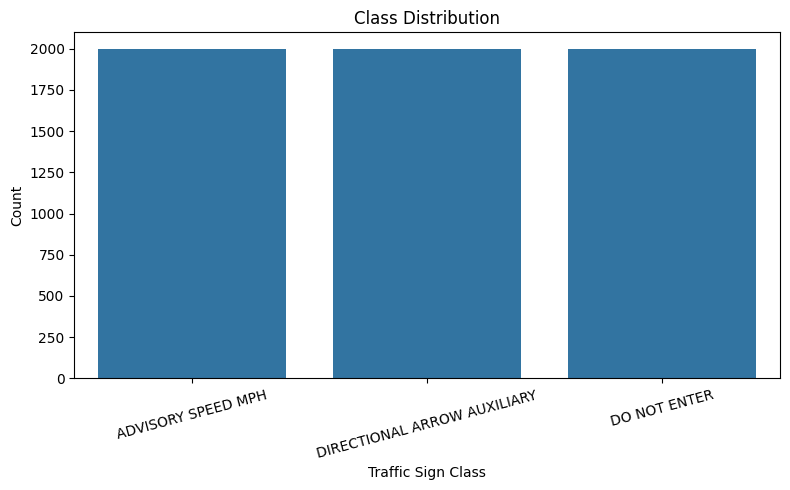

In [48]:

# Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Traffic Sign Class')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [50]:

# Calculate bounding box dimensions
df['bbox_width'] = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']



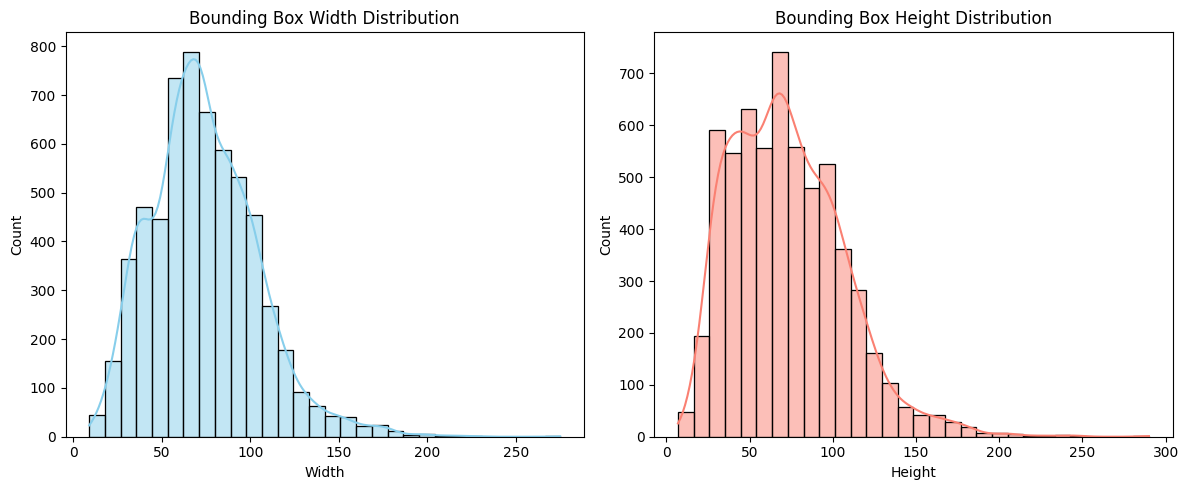

In [52]:
# Plot bounding box width and height distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['bbox_width'], bins=30, kde=True, color='skyblue')
plt.title('Bounding Box Width Distribution')
plt.xlabel('Width')

plt.subplot(1, 2, 2)
sns.histplot(df['bbox_height'], bins=30, kde=True, color='salmon')
plt.title('Bounding Box Height Distribution')
plt.xlabel('Height')

plt.tight_layout()
plt.show()



In [34]:

# Correlation analysis (optional)
print("\n📈 Correlation Matrix:")
print(df[['xmin', 'xmax', 'ymin', 'ymax', 'bbox_width', 'bbox_height']].corr())


📈 Correlation Matrix:
                 xmin      xmax      ymin      ymax  bbox_width  bbox_height
xmin         1.000000  0.998481  0.371525  0.321414   -0.096216    -0.197733
xmax         0.998481  1.000000  0.353022  0.319707   -0.041232    -0.151136
ymin         0.371525  0.353022  1.000000  0.931823   -0.359843    -0.360805
ymax         0.321414  0.319707  0.931823  1.000000   -0.052950     0.002263
bbox_width  -0.096216 -0.041232 -0.359843 -0.052950    1.000000     0.855461
bbox_height -0.197733 -0.151136 -0.360805  0.002263    0.855461     1.000000


In [53]:
# Unique images per class
unique_imgs_per_class = df.groupby('class')['filename'].nunique()
print("\n📸 Unique Images per Class:")
print(unique_imgs_per_class)






📸 Unique Images per Class:
class
ADVISORY SPEED MPH             1994
DIRECTIONAL ARROW AUXILIARY    1653
DO NOT ENTER                   1994
Name: filename, dtype: int64


In [56]:
# Duplicate annotations
duplicates = df.duplicated()
print(f"\n Total Duplicate Annotations: {duplicates.sum()}")
# Invalid bounding boxes (zero or negative size)
invalid_boxes = df[(df['bbox_width'] <= 0) | (df['bbox_height'] <= 0)]
print(f" Invalid Bounding Boxes (Width/Height <= 0): {len(invalid_boxes)}")


 Total Duplicate Annotations: 18
 Invalid Bounding Boxes (Width/Height <= 0): 0
